In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

#### Flow Like Water

In [3]:
with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    frontier_sample_data = pickle.load(file)
the_frontier_eddies = list(frontier_sample_data.keys())
# Depths will be limited to COW depths
d_df = pd.DataFrame(columns=['T' + str(t) for t in range(30)])
for eddy in the_frontier_eddies:
    row = []
    for t in range(30):
        df = frontier_sample_data[eddy]['T' + str(t)]['COW']['x']
        row.append(df.isna().idxmax() if df.isna().any() else len(df))
    d_df.loc[eddy] = row

eddy = the_frontier_eddies[0]

sub_data = {}

for t in range(30):
    
    method = 'VG'
    sub_data['T'+str(t)] = {}
    
    df = frontier_sample_data[eddy]['T'+str(t)][method].iloc[:d_df.loc[eddy]['T'+str(t)]]
    df = df.drop('TD', axis=1)
    
    # Interpolate to Density intervals
    rho = frontier_sample_data[eddy]['T'+str(t)]['rho']
    X, Y = np.meshgrid(frontier_sample_data[eddy]['T'+str(t)]['x'],
                       frontier_sample_data[eddy]['T'+str(t)]['y'])
    points = np.column_stack((X.ravel(), Y.ravel()))
    rhoc = []
    for k, (xc, yc) in enumerate(zip(df['x'], df['y'])):
        values = rho[:, :, k].ravel()
        target_point = np.array([[xc, yc]])
        rhoc.append(griddata(points, values, target_point, method='linear')[0])
    RHO_INT = 0.05
    new_rho = np.arange(np.floor(np.nanmin(rhoc) / RHO_INT) * RHO_INT,
                        np.ceil(np.nanmax(rhoc) / RHO_INT) * RHO_INT + RHO_INT,
                        RHO_INT)
    rho_data = pd.DataFrame({
        'x': np.interp(new_rho, rhoc, df['x']),
        'y': np.interp(new_rho, rhoc, df['y']),
        'Depth': np.interp(new_rho, rhoc, df['Depth']),
        'rho': new_rho
    })
    # TD_DENSITY = 26
    # x0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['x']
    # y0 = rho_data.loc[np.isclose(rho_data['rho'], TD_DENSITY)].iloc[0]['y']
    x0 = rho_data.iloc[0]['x']
    y0 = rho_data.iloc[0]['y']
    rho_data['x'] = rho_data['x'] - x0
    rho_data['y'] = rho_data['y'] - y0
    rho_data['TD'] = np.hypot(rho_data['x'], rho_data['y'])
    
    # Interpolate to Depth intervals
    DEPTH_INT = 10
    new_depth = np.arange(0, -np.floor(df['Depth'].min()/DEPTH_INT) * DEPTH_INT + DEPTH_INT, DEPTH_INT)
    depth_data = pd.DataFrame({
        'x': np.interp(new_depth, -df['Depth'], df['x']),
        'y': np.interp(new_depth, -df['Depth'], df['y']),
        'Depth': -new_depth,
        'rho': np.interp(new_depth, -df['Depth'], rhoc),
    })
    # TD_DEPTH = -150
    # x0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['x']
    # y0 = depth_data.loc[np.isclose(depth_data['Depth'], TD_DEPTH)].iloc[0]['y']
    x0 = depth_data.iloc[0]['x']
    y0 = depth_data.iloc[0]['y']
    depth_data['x'] = depth_data['x'] - x0
    depth_data['y'] = depth_data['y'] - y0
    depth_data['TD'] = np.hypot(depth_data['x'], depth_data['y'])

    sub_data['T'+str(t)]['rho_data'] = rho_data
    sub_data['T'+str(t)]['depth_data'] = depth_data
    print(t)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


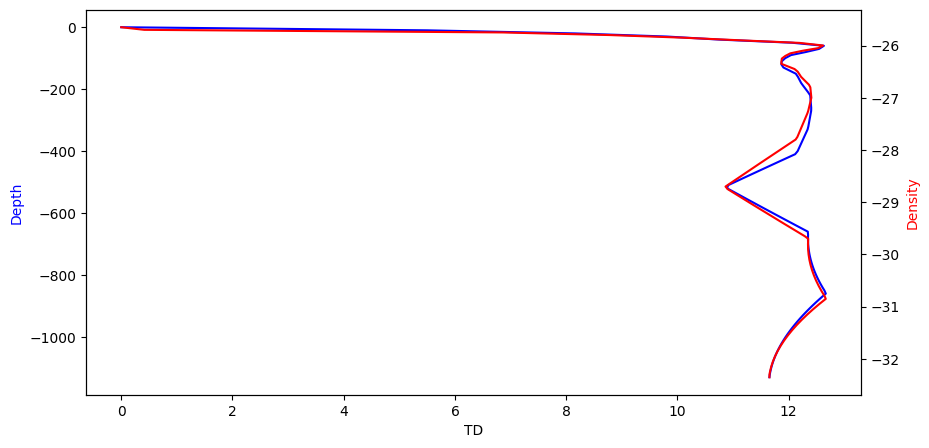

In [4]:
fig, ax1 = plt.subplots(figsize=(10, 5))
# Plot depth data
ax1.plot(depth_data['TD']/1000, depth_data['Depth'], 'b-')
ax1.set_xlabel('TD')
ax1.set_ylabel('Depth', color='b')

# Create a second y-axis for density data
ax2 = ax1.twinx()
ax2.plot(rho_data['TD']/1000, -rho_data['rho'], 'r-')
ax2.set_ylabel('Density', color='r')

plt.show()

### Best Shift with rho

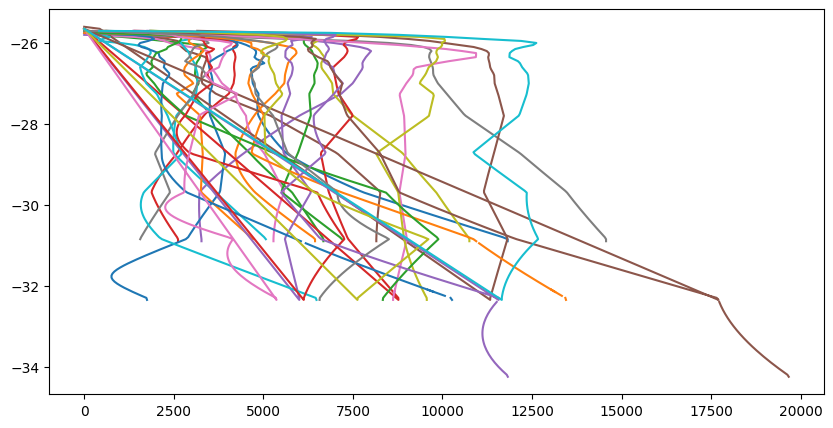

In [5]:
plt.figure(figsize=(10, 5))

medium = 'TD'
dfs_x = []
dfs_y = []
dfs_TD = []
for t in range(30):
    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'x']]
    rho_data.columns = ['rho', 'x'+str(t)]
    dfs_x.append(rho_data.set_index('rho'))  

    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'y']]
    rho_data.columns = ['rho', 'y'+str(t)]
    dfs_y.append(rho_data.set_index('rho'))  

    rho_data = sub_data['T'+str(t)]['rho_data'][['rho', 'TD']]
    rho_data.columns = ['rho', 'TD'+str(t)]
    dfs_TD.append(rho_data.set_index('rho'))  

rho_df_x = pd.concat(dfs_x, axis=1) 
rho_df_y = pd.concat(dfs_y, axis=1) 
rho_df_TD = pd.concat(dfs_TD, axis=1) 

for col in rho_df_TD.columns:
    plt.plot(rho_df_TD[col], -rho_df_TD.index)


In [6]:
rho_df_x

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29
rho,,,,,,,,,,,,,,,,,,,,,
25.75,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25.80,-229.138002,-148.244910,194.968940,450.589182,0.000000,-438.501443,-22.334369,-872.255736,-1239.114610,NaN,...,1352.092264,2364.579438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25.85,-2005.849782,-2897.354259,1039.336050,2770.814085,4086.116082,-1606.841504,533.311571,-3213.540905,-1266.193619,NaN,...,1845.095293,3469.269476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25.90,-3024.228853,-3990.545758,1688.652959,3597.204291,5541.666388,-2123.617711,1555.011390,-4309.053763,-979.224151,NaN,...,1901.375988,4083.639142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25.95,-3772.927914,-4606.410543,2131.493025,4013.268026,6130.875953,-2323.125233,1982.784435,-4988.084422,-612.345915,NaN,...,1656.475758,4378.019141,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7583.246034,19118.681269,NaN,NaN,NaN,NaN
34.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7759.716245,19221.273101,NaN,NaN,NaN,NaN
34.15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,7936.186457,19323.864933,NaN,NaN,NaN,NaN


In [7]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg)  # Convert degrees to radians
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

x0, y0 = rho_df_x['x14']/1000, rho_df_y['y14']/1000
points0 = np.column_stack((x0, y0))

shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'rmse'])

tic = time.time()
for t in range(0, 30):

    x, y = rho_df_x['x'+str(t)]/1000, rho_df_y['y'+str(t)]/1000
    points = np.column_stack((x, y))

    for theta_shift in np.arange(0, 360, 10):
        
        points_rotated = rotate_y_xy(points, theta_shift)

        for i_shift in range(-10, 10):
            for j_shift in range(-10, 10):

                points_shifted = np.column_stack((points_rotated[:,0] + i_shift,
                                                  points_rotated[:,1] + j_shift))

                if not np.all(np.isnan(points_shifted - points0)):
                    rmse = np.sqrt(np.nanmean((points_shifted - points0) ** 2))
                else:
                    rmse = np.nan
                
                shift_df.loc[len(shift_df)] = {
                    'Day': t,
                    'theta': theta_shift,
                    'i': i_shift,
                    'j': j_shift,
                    'rmse': rmse
                }
    print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

rho_best_shift_df = pd.DataFrame()
for t in shift_df['Day'].unique():
    day_df = shift_df.loc[shift_df['Day'] == t]
    if not np.all(np.isnan(day_df['rmse'])):
        rho_best_shift_df = pd.concat([rho_best_shift_df, day_df.loc[[day_df['rmse'].idxmin()]]])
rho_best_shift_df

# with open('/srv/scratch/z5297792/Sample/rho_best_shift'+eddy+'.pkl', 'wb') as file:
#     pickle.dump(rho_best_shift_df, file)

# with open('/srv/scratch/z5297792/Sample/rho_best_shift'+eddy+'.pkl', 'rb') as file:
#     rho_best_shift_df = pickle.load(file)

# 40 min for 5 days

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
Elapsed time: 2665.4999 seconds


,Day,theta,i,j,rmse
142172,9,310,-2,2,0.656693
145691,10,40,-6,1,1.067160
160193,11,40,-1,3,0.464003
184231,12,280,1,1,0.658379
198251,13,270,2,1,0.720924
201810,14,0,0,0,0.000000
224286,15,200,4,-4,0.833856
238659,16,200,2,9,0.098838
255331,17,260,-4,1,0.611663
271491,18,300,4,1,0.736739


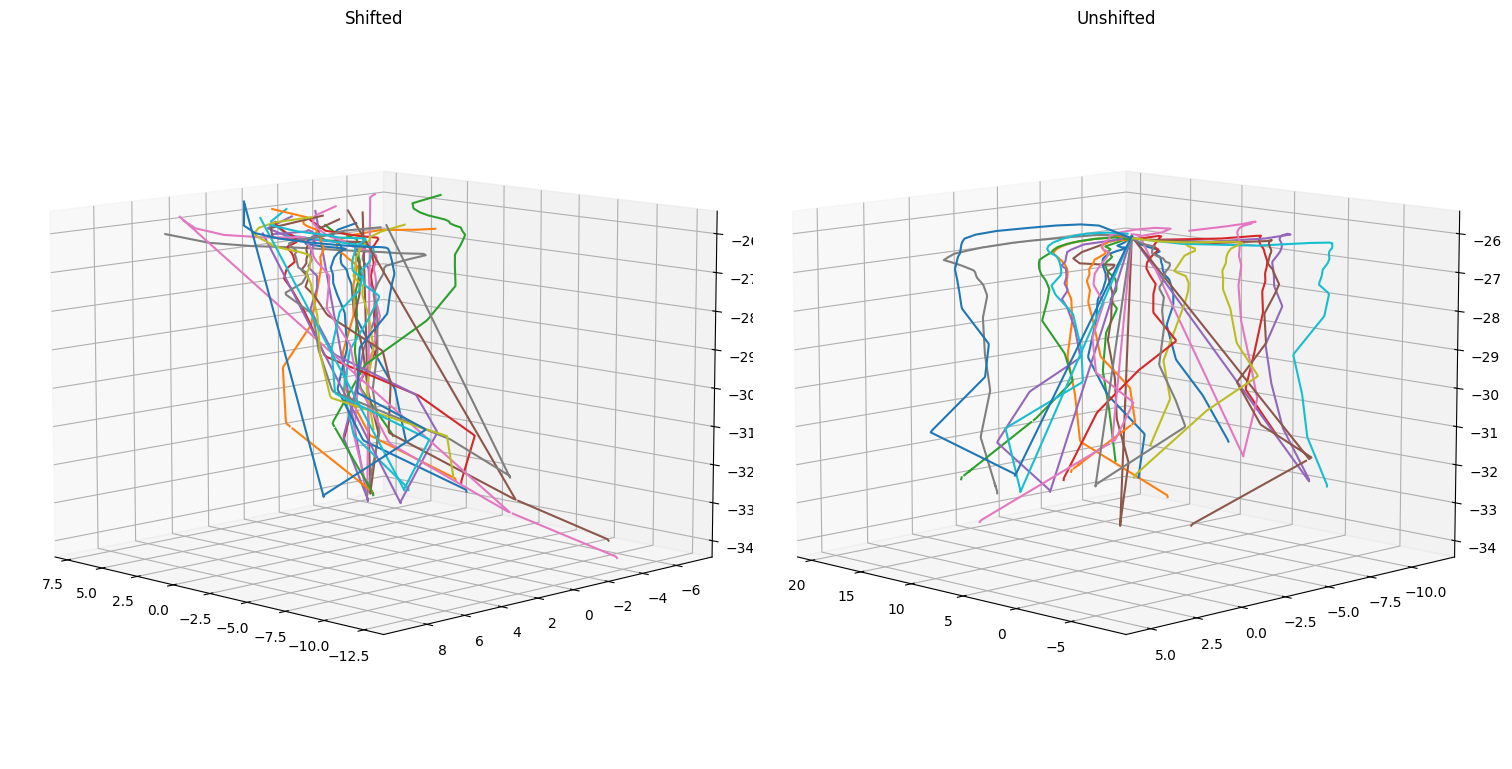

In [8]:
fig = plt.figure(figsize=(15, 10))

# First subplot
ax1 = fig.add_subplot(121, projection='3d')
for _, row in rho_best_shift_df.iterrows():
    t, theta, i, j, rmse = int(row['Day']), row['theta'], row['i'], row['j'], row['rmse']
    if rmse < 100:
        x, y = rho_df_x[f'x{t}']/1000, rho_df_y[f'y{t}']/1000
        x, y = rotate_y_xy(np.column_stack((x, y)), theta).T
        x, y = x + i, y + j
        ax1.plot(x, y, -rho_df_x.index)

ax1.view_init(elev=10, azim=135)
ax1.set_title('Shifted')

# Second subplot
ax2 = fig.add_subplot(122, projection='3d')
for _, row in rho_best_shift_df.iterrows():
    t, theta, i, j = int(row['Day']), row['theta'], row['i'], row['j']
    x, y = rho_df_x[f'x{t}']/1000, rho_df_y[f'y{t}']/1000
    ax2.plot(x, y, -rho_df_x.index)

ax2.view_init(elev=10, azim=135)
ax2.set_title('Unshifted')

plt.tight_layout()
plt.show()


In [44]:
Normalized_df = pd.DataFrame(index=rho_df_x.index)

for _, row in rho_best_shift_df.iterrows():
    t, theta, i, j, rmse = int(row['Day']), row['theta'], row['i'], row['j'], row['rmse']
    if rmse < 2:
        x, y = rho_df_x[f'x{t}'], rho_df_y[f'y{t}']
        x, y = rotate_y_xy(np.column_stack((x, y)), theta).T
        x, y = x + i, y + j

        Normalized_df['x'+str(t)] = x
        Normalized_df['y'+str(t)] = y


In [39]:
Normalized_df

,x0,y0,x1,y1,x2,y2,x3,y3,x4,y4,...,x21,y21,x22,y22,x25,y25,x26,y26,x27,y27
rho,,,,,,,,,,,,,,,,,,,,,
24.50,0.000000,7.000000,-7.000000,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.55,1176.229254,1352.457789,-44.257833,-734.547593,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.60,733.831970,269.689697,-196.527628,-7970.550084,-8.000000,9.000000,NaN,NaN,1.000000,4.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.65,498.065381,-329.835870,212.205106,-10087.694688,-616.829829,-2913.857437,-3.000000,8.000000,168.752604,-88.888872,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24.70,525.688557,-1098.004389,1573.127896,-10930.240043,173.262606,-4731.859088,3606.200211,-3189.497495,2207.266517,-874.587883,...,-8.0,8.0,-1.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32.05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1614.676212,8328.401725,9506.162486,8719.165477,4434.654327,9244.869960
32.20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1101.109682,7965.000486,9184.272985,8830.459760,4248.891378,9603.565427
32.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,929.920839,7843.866740,9076.976484,8867.557854,4186.970395,9723.130583


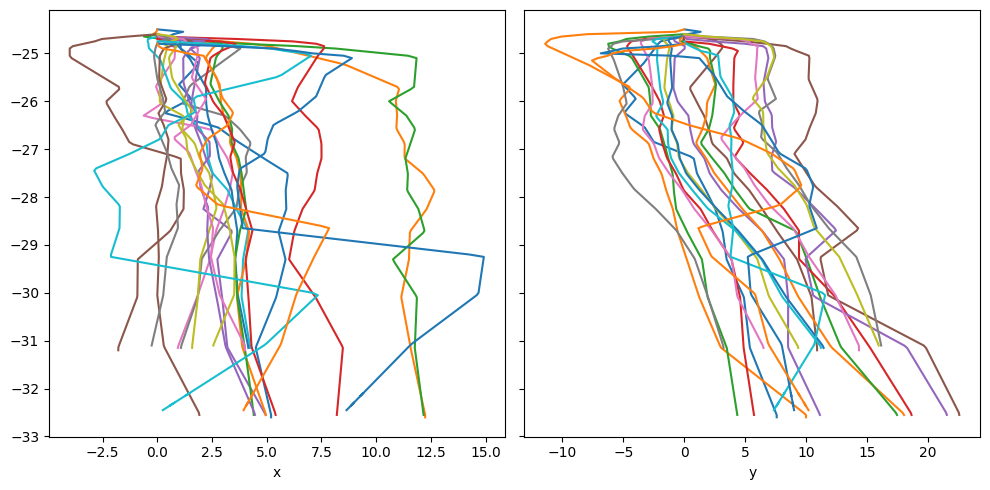

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)

for col in Normalized_df.columns:
    if 'x' in col:
        axs[0].plot(Normalized_df[col]/1000, -Normalized_df.index)
        axs[0].set_xlabel('x')
    if 'y' in col:
        axs[1].plot(Normalized_df[col]/1000, -Normalized_df.index)
        axs[1].set_xlabel('y')

plt.tight_layout()
plt.show()


### Best shift with Depth


In [ ]:
plt.figure(figsize=(10, 5))

medium = 'TD'
dfs_x = []
dfs_y = []
dfs_TD = []
for t in range(30):
    depth_data = sub_data['T'+str(t)]['depth_data'][['Depth', 'x']]
    depth_data.columns = ['Depth', 'x'+str(t)]
    dfs_x.append(depth_data.set_index('Depth'))  

    depth_data = sub_data['T'+str(t)]['depth_data'][['Depth', 'y']]
    depth_data.columns = ['Depth', 'y'+str(t)]
    dfs_y.append(depth_data.set_index('Depth'))  

    depth_data = sub_data['T'+str(t)]['depth_data'][['Depth', 'TD']]
    depth_data.columns = ['Depth', 'TD'+str(t)]
    dfs_TD.append(depth_data.set_index('Depth'))  

depth_df_x = pd.concat(dfs_x, axis=1) 
depth_df_y = pd.concat(dfs_y, axis=1) 
depth_df_TD = pd.concat(dfs_TD, axis=1) 

for col in depth_df_TD.columns:
    plt.plot(depth_df_TD[col], depth_df_TD.index)


In [ ]:
depth_df_x

In [ ]:
def rotate_y_xy(points, theta_deg):
    """Rotate points (x, y) about the y-axis by angle theta (in degrees)."""
    theta = np.deg2rad(theta_deg)  # Convert degrees to radians
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    xy_rotated = np.dot(points[:, :2], rotation_matrix.T)
    return np.hstack((xy_rotated, points[:, 2:]))

x0, y0 = depth_df_x['x14']/1000, depth_df_y['y14']/1000
points0 = np.column_stack((x0, y0))

shift_df = pd.DataFrame(columns=['Day', 'theta', 'i', 'j', 'rmse'])

tic = time.time()
for t in range(0, 25):

    x, y = depth_df_x['x'+str(t)]/1000, depth_df_y['y'+str(t)]/1000
    points = np.column_stack((x, y))

    for theta_shift in np.arange(0, 360, 30):
        
        points_rotated = rotate_y_xy(points, theta_shift)

        for i_shift in range(15, 15):
            for j_shift in range(-15, 15):

                points_shifted = np.column_stack((points_rotated[:,0] + i_shift,
                                                  points_rotated[:,1] + j_shift))

                if not np.all(np.isnan(points_shifted - points0)):
                    rmse = np.sqrt(np.nanmean((points_shifted - points0) ** 2))
                else:
                    rmse = np.nan
                
                shift_df.loc[len(shift_df)] = {
                    'Day': t,
                    'theta': theta_shift,
                    'i': i_shift,
                    'j': j_shift,
                    'rmse': rmse
                }
    print(t)
toc = time.time()
print(f"Elapsed time: {toc - tic:.4f} seconds")

depth_best_shift_df = pd.DataFrame()
for t in shift_df['Day'].unique():
    day_df = shift_df.loc[shift_df['Day'] == t]
    if np.all(np.isnan(day_df['rmse'])):
        depth_best_shift_df = pd.concat([depth_best_shift_df, day_df.iloc[0]])
    else:
        depth_best_shift_df = pd.concat([depth_best_shift_df, day_df.loc[[day_df['rmse'].idxmin()]]])
depth_best_shift_df

with open('/srv/scratch/z5297792/Sample/depth_best_shift'+eddy+'.pkl', 'wb') as file:
    pickle.dump(depth_best_shift_df, file)
# 40 min for 5 days

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for _, row in best_shift_df.iterrows():
    t, theta, i, j = int(row['Day']), row['theta'], row['i'], row['j']

    x, y = depth_df_x[f'x{t}']/1000, depth_df_y[f'y{t}']/1000
    x, y = rotate_y_xy(np.column_stack((x, y)), theta).T
    x, y = x + i, y + j

    ax.plot(x, y, depth_df_x.index)
ax.view_init(elev=10, azim=135)

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for _, row in best_shift_df.iterrows():
    t, theta, i, j = int(row['Day']), row['theta'], row['i'], row['j']

    x, y = depth_df_x[f'x{t}']/1000, depth_df_y[f'y{t}']/1000

    ax.plot(x, y, depth_df_x.index)
ax.view_init(elev=10, azim=135)